## Readme

Due to the limitations on Codespaces, I have decided to do a downscaled version of the exercise, using a sample of the images provided. The sample consists of 200 images for each class and 100 unlabeled images for testing the model.

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import random
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, MaxPool2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

2024-10-16 18:02:04.208016: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-16 18:02:04.211476: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-16 18:02:04.221065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 18:02:04.236159: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 18:02:04.240460: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 18:02:04.252761: I tensorflow/core/platform/cpu_feature_gu

Data preparation

In [2]:
#Train Data

# Path to the directory where images were extracted
train_dir = 'data/dogs-vs-cats/train'

#Using data augmentation to artificially increase the size of the training dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Rescale pixel values to [0, 1]
    rotation_range=40,         # Random rotations
    width_shift_range=0.2,     # Random horizontal shifts
    height_shift_range=0.2,    # Random vertical shifts
    shear_range=0.2,           # Shear transformations
    zoom_range=0.2,            # Random zooms
    horizontal_flip=True,      # Random horizontal flips
    fill_mode='nearest'        # Fill any new pixels with nearest value
)

# Train generator for the labeled training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),    # Resize images to 200x200 pixels
    batch_size=25,
    class_mode='binary'
)

Found 400 images belonging to 2 classes.


In [3]:
#Test data

# Path to your test directory
test_dir = 'data/dogs-vs-cats/test1'

# List all images in the directory
test_images = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir) if fname.endswith('.jpg') or fname.endswith('.png')]

# Function to load and preprocess a single image
def load_and_preprocess_image(img_path, target_size=(200, 200)):
    img = image.load_img(img_path, target_size=target_size)
    img = image.img_to_array(img)
    img = img / 255.0  # Rescale to [0, 1]
    return np.expand_dims(img, axis=0)  # Add batch dimension

# Batch size to control memory usage
batch_size = 25  # Adjust batch size based on available memory

# Process images in batches
for i in range(0, len(test_images), batch_size):
    batch_images = test_images[i:i + batch_size]  # Get the current batch of images
    preprocessed_images = []

    # Load and preprocess the current batch of images
    for img_path in batch_images:
        img = load_and_preprocess_image(img_path)
        preprocessed_images.append(img)

    # Convert the list of images to a NumPy array for model prediction
    test_data = np.vstack(preprocessed_images)

print("Processing complete.")

Processing complete.


Building the model

In [4]:
model = Sequential()

# Use the Input layer to specify the input shape
model.add(Input(shape=(200, 200, 3)))  # Image size: 200x200 with 3 color channels (RGB)

# Add convolutional and pooling layers
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
#L2 regularization to penalizes large weights
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [5]:
# Compile the model
#Reduced learning rate for smaller dataset
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [6]:
# Add Callbacks
checkpoint_callback = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=25,
    callbacks=[checkpoint_callback, early_stopping_callback],
     batch_size=32
)

/workspaces/downscaled-image-classifier-project-tutorial/cnn_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5328 - loss: 9.8411
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/25


/workspaces/downscaled-image-classifier-project-tutorial/cnn_env/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/workspaces/downscaled-image-classifier-project-tutorial/cnn_env/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
2024-10-16 18:02:32.215058: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/codespace/.python/current/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use 

16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5469 - loss: 6.2868
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/25


2024-10-16 18:02:55.505326: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5577 - loss: 3.9230
Epoch 6/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6051 - loss: 2.4739
Epoch 8/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/25


2024-10-16 18:03:42.883709: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


16/16 ━━━━━━━━━━━━━━━━━━━━ 79s 5s/step - accuracy: 0.5706 - loss: 1.6614
Epoch 10/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5781 - loss: 1.2096
Epoch 12/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 13/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5341 - loss: 0.9991
Epoch 14/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 15/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.5931 - loss: 0.8557
Epoch 16/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00


2024-10-16 18:06:12.683871: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 17/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6333 - loss: 0.7772
Epoch 18/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 19/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6653 - loss: 0.7218
Epoch 20/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 21/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6517 - loss: 0.7139
Epoch 22/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 23/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - accuracy: 0.6221 - loss: 0.6924
Epoch 24/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 25/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6585 - loss: 0.6743


In [26]:
#Saving the model
model.save("models/cnn_cats-vs-dogs.keras")

## Alternate approach
Using a pretrained model such as MobileNetv2, then training on top of it, a better accuracy score can be achieved.

In [27]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# Load the MobileNetV2 model, excluding the top layers
base_model = MobileNetV2(input_shape=(200, 200, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

/tmp/ipykernel_27285/2572477314.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(200, 200, 3), include_top=False, weights='imagenet')


In [28]:
# Compile the model
#Reduced learning rate for smaller dataset
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
# Add Callbacks
checkpoint_callback = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=25,
    callbacks=[checkpoint_callback, early_stopping_callback],
     batch_size=32
)

Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 550ms/step - accuracy: 0.5410 - loss: 0.8909
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/25


/workspaces/downscaled-image-classifier-project-tutorial/cnn_env/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/workspaces/downscaled-image-classifier-project-tutorial/cnn_env/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/home/codespace/.python/current/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 554ms/step - accuracy: 0.8176 - loss: 0.4738
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 554ms/step - accuracy: 0.9028 - loss: 0.2633
Epoch 6/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 538ms/step - accuracy: 0.9138 - loss: 0.2166
Epoch 8/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 496ms/step - accuracy: 0.9351 - loss: 0.1782
Epoch 10/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 486ms/step - accuracy: 0.9249 - loss: 0.1900
Epoch 12/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 13/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 498ms/step - accuracy: 0.9269 - loss: 0.1597
Epoch 14/25
16/16 ━━━

2024-10-16 18:49:21.197052: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 536ms/step - accuracy: 0.9435 - loss: 0.1292
Epoch 18/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 19/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 554ms/step - accuracy: 0.9598 - loss: 0.1028
Epoch 20/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 21/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 553ms/step - accuracy: 0.9656 - loss: 0.1233
Epoch 22/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 23/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 537ms/step - accuracy: 0.9493 - loss: 0.1048
Epoch 24/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 25/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 533ms/step - accuracy: 0.9569 - loss: 0.1059


In [30]:
#Saving the model
model.save("models/mobileNet_dogs-vs-cats.keras")

## Testing the models

In [32]:
from tensorflow.keras.models import load_model
cnn_model = load_model('models/cnn_cats-vs-dogs.keras')
mobileNet_model = load_model('models/mobileNet_dogs-vs-cats.keras')

First model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


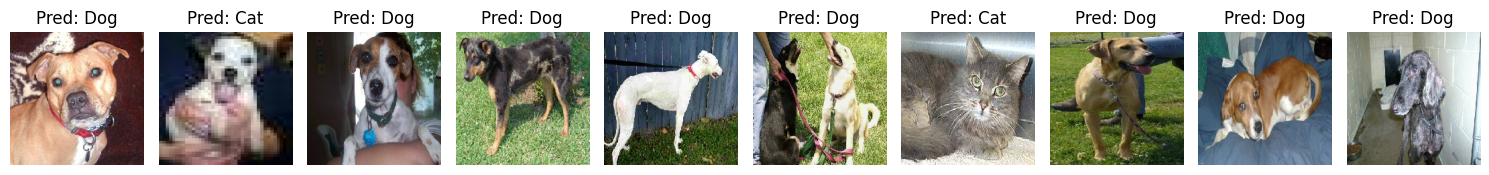

In [33]:
# Specify the number of images you want to test
num_images_to_test = 10
# Select a random subset of images
test_images_subset = random.sample(test_images, num_images_to_test)
# Initialize a list to store predictions
predictions = []

# Process images one by one
for img_path in test_images_subset:
    # Preprocess the image
    img = load_and_preprocess_image(img_path)
    
    # Make prediction on the image
    prediction = cnn_model.predict(img)
    
    # For binary classification (cat vs dog), we assume a sigmoid activation
    if len(prediction[0]) == 1:  # For binary classification
        predicted_class = 'Dog' if prediction[0] > 0.5 else 'Cat'
        predicted_score = prediction[0][0]  # Use the scalar value
    else:  # For multi-class classification
        predicted_class = np.argmax(prediction, axis=-1)
        predicted_score = np.max(prediction)  # Use the max probability
    
    # Store the image path, predicted class, and the prediction score
    predictions.append((img_path, predicted_class, predicted_score))

# Plot images with their predictions
fig, axes = plt.subplots(1, num_images_to_test, figsize=(15, 15))

for i, (img_path, predicted_class, predicted_score) in enumerate(predictions):
    # Load the image to display
    img = image.load_img(img_path, target_size=(200, 200))
    
    # Display the image
    axes[i].imshow(img)
    axes[i].axis('off')
    
    # Display the predicted class and prediction score
    axes[i].set_title(f"Pred: {predicted_class}")

plt.tight_layout()
plt.show()

Optimized model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


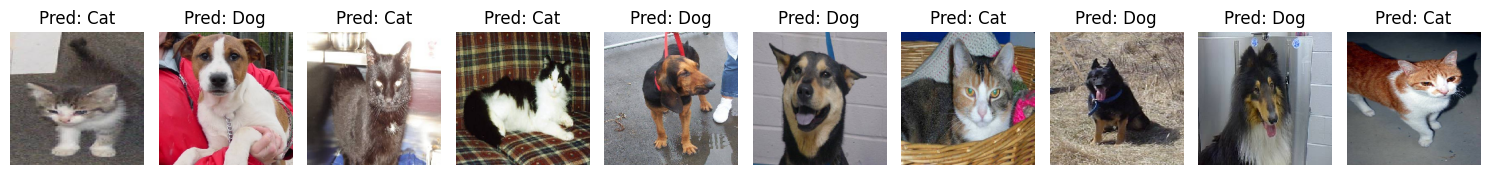

In [35]:
# Specify the number of images you want to test
num_images_to_test = 10
# Select a random subset of images
test_images_subset = random.sample(test_images, num_images_to_test)
# Initialize a list to store predictions
predictions = []

# Process images one by one
for img_path in test_images_subset:
    # Preprocess the image
    img = load_and_preprocess_image(img_path)
    
    # Make prediction on the image
    prediction = mobileNet_model.predict(img)

    if len(prediction[0]) == 1:  # For binary classification
        predicted_class = 'Dog' if prediction[0] > 0.5 else 'Cat'
        predicted_score = prediction[0][0]  # Use the scalar value
    else:  # For multi-class classification
        predicted_class = np.argmax(prediction, axis=-1)
        predicted_score = np.max(prediction)  # Use the max probability
    
    # Store the image path, predicted class, and the prediction score
    predictions.append((img_path, predicted_class, predicted_score))

# Plot images with their predictions
fig, axes = plt.subplots(1, num_images_to_test, figsize=(15, 15))

for i, (img_path, predicted_class, predicted_score) in enumerate(predictions):
    # Load the image to display
    img = image.load_img(img_path, target_size=(200, 200))
    
    # Display the image
    axes[i].imshow(img)
    axes[i].axis('off')
    
    # Display the predicted class and prediction score
    axes[i].set_title(f"Pred: {predicted_class}")

plt.tight_layout()
plt.show()

## Conclusion

The second model's accuracy is significantly better(~95%).